참고: 이 노트북을 사용하려면 **파이토치 2.0, 파이썬 3.10, GPU 커널이 있는 g4dn.xlarge** 인스턴스를 사용하세요.

# https://github.com/kvablack/ddpo-pytorch
# ddpo-pytorch
이 프로젝트는 파이토치로 구현한 [노이즈 제거 확산 정책 최적화(Denoising Diffusion Policy Optimization; DDPO)](https://rl-diffusion.github.io/)로 저순위 적응(Low-Rank Adaptation; LoRA)을 지원합니다. 원래의 연구 코드([여기](https://github.com/jannerm/ddpo)서 확인 가능)와 달리 이 구현체는 GPU에서 실행되며, LoRA를 활성화하면 10GB 미만의 GPU 메모리로 스테이블 디퓨전 모델을 미세 조정할 수 있습니다.

![DDPO](teaser.jpg)

## 설치
파이썬 3.10 이상 버전이 필요합니다.

```bash
git clone git@github.com:kvablack/ddpo-pytorch.git
cd ddpo-pytorch
pip install -e .
```

## 사용법
이 명령을 실행하면 `ddpo_config/base.py`의 설정을 사용해 스테이블 디퓨전 v1.5를 압축 성능 향상 관점에서 즉시 미세 조정하기 시작하며, 사용 가능한 모든 GPU를 활용합니다. 각 GPU의 메모리가 최소 10GB만 있으면 작동합니다. wandb에 로그인하고 싶지 않다면 위 명령어를 실행하기 전에 `wandb disabled`을 먼저 실행하세요.

`ddpo_config/base.py`의 기본 하이퍼파라미터는 좋은 성능을 내기 위한 것이 아니라 코드를 최대한 빨리 실행하기 위한 것입니다. 학습 샘플 수를 크게 늘리고 그래디언트 누적(gradient accumulation) 단계를 활용하지 않으면 좋은 결과를 얻기 어려울 것입니다.

## 중요한 하이퍼파라미터

모든 하이퍼파라미터에 대한 자세한 설명은 `ddpo_config/base.py`에서 확인할 수 있습니다. 다음은 몇 가지 중요한 하이퍼파라미터입니다.

### prompt_fn 및 reward_fn
상위 수준에서 보면 확산 모델의 미세 조정 문제는 이미지를 생성하기 위한 프롬프트 세트와 생성된 이미지를 평가하는 보상 함수, 이 두 가지로 정의됩니다. 프롬프트는 인수를 받지 않고 호출될 때마다 무작위 프롬프트를 생성하는 `prompt_fn`으로 정의됩니다. 보상 함수는 이미지 배치를 받아 해당 이미지에 대한 보상값 배치를 반환하는 `reward_fn`으로 정의됩니다. 현재 구현된 모든 프롬프트 함수와 보상 함수는 각각 `ddpo_pytorch/prompts.py`와 `ddpo_pytorch/rewards.py`에서 확인할 수 있습니다.

### 배치 크기 및 그래디언트 누적 단계
각 DDPO 에포크는 이미지 배치를 생성하고, 보상을 계산한 다음, 해당 이미지에 대해 몇 가지 학습 단계를 수행하는 과정으로 구성됩니다. 한 가지 중요한 하이퍼파라미터는 에포크당 생성되는 이미지 수입니다. 평균 보상과 정책 그래디언트를 잘 추정하려면 충분한 수의 이미지가 필요합니다. 또 다른 중요한 하이퍼파라미터는 에포크당 학습 단계 수입니다.

그러나 이러한 값은 명시적으로 정의되지 않고, 다른 여러 하이퍼파라미터에 의해 암묵적으로 정의됩니다. 먼저 모든 배치 크기는 **GPU당**으로 지정된다는 점에 유의하세요. 따라서 에포크당 생성되는 총 이미지 수는 `sample.batch_size * num_gpus * sample.num_batches_per_epoch`입니다. 유효한 총 학습 배치 크기(다중 GPU 학습과 그래디언트 누적을 포함하는 경우)는 `train.batch_size * num_gpus * train.gradient_accumulation_steps`입니다. 에포크당 학습 단계 수는 첫 번째 수를 두 번째 수로 나눈 값, 즉 `(sample.batch_size * sample.num_batches_per_epoch) / (train.batch_size * train.gradient_accumulation_steps)`입니다.

(여기서 `train.num_inner_epochs == 1`이라고 가정합니다. 이 값을 더 높게 설정하면 새로운 이미지 배치를 생성하기 전에 동일한 이미지 배치에 대해 여러 번 학습을 반복하게 되며, 에포크당 학습 단계 수는 그에 따라 곱해집니다.)

각 학습 실행 시, 스크립트는 에포크당 생성된 이미지 수, 효과적인 총 학습 배치 크기 및 에포크당 학습 단계 수를 계산해 출력합니다. 이 숫자들을 반드시 확인하기 바랍니다.


## 결과 재현
이 README 상단의 이미지는 LoRA 사용해 생성됐습니다! 그러나 8개의 A100 GPU가 있는 상당히 강력한 DGX 머신을 사용했으며, 각 실험은 100 에포크를 진행하는 데 약 4시간이 소요됐습니다. 단일 소형 GPU로 동일한 실험을 실행하려면 `sample.batch_size = train.batch_size = 1`로 설정하고 `sample.num_batches_per_epoch`와 `train.gradient_accumulation_steps`를 그에 따라 곱해야 합니다.

4개의 실험에 사용한 정확한 설정은 `ddpo_config/dgx.py`에서 확인할 수 있습니다.

언어-이미지 시각 어시스턴트(Language-Image Visual Assistant; LLaVA) 프롬프트-이미지 정렬 실험을 실행하려면, [이 저장소](https://github.com/kvablack/LLaVA-server/)를 사용해 LLaVA 추론을 실행하는 데 몇 개의 GPU를 할당해야 합니다.

## 보상 곡선
<img src="https://github.com/kvablack/ddpo-pytorch/assets/12429600/593c9be3-e2a7-45d8-b1ae-ca4f77197c18" width="49%">
<img src="https://github.com/kvablack/ddpo-pytorch/assets/12429600/d12fef0a-68b8-4cef-a9b8-cb1b6878fcec" width="49%">
<img src="https://github.com/kvablack/ddpo-pytorch/assets/12429600/68c6a7ac-0c31-4de6-a7a0-1f9bb20202a4" width="49%">
<img src="https://github.com/kvablack/ddpo-pytorch/assets/12429600/393a929e-36af-46f2-8022-33384bdae1c8" width="49%">


심미성 실험에서 볼 수 있듯이, 충분히 오래 실행하면 알고리즘은 결국 불안정성을 겪게 됩니다. 이는 학습률을 감쇠시켜 해결할 수 있습니다. 그러나 흥미롭게도 불안정성이 발생한 후에 얻은 실제 정성적 샘플은 대부분 괜찮습니다. 평균 점수의 하락은 몇 개의 낮은 점수를 받은 이상치로 인해 발생합니다. 이는 wandb에서 개별 실행 결과를 확인하면 볼 수 있는 전체 보상 히스토그램에서 분명히 드러납니다.

<img src="https://github.com/kvablack/ddpo-pytorch/assets/12429600/eda43bef-6363-45b5-829d-466502e0a0e3" width="50%">



# 활용 사례는 어떤 것이 있나요?
이 실습에서는 합성된 위성 이미지를 생성합니다. 이 이미지는 연구에 사용되거나 컴퓨터 비전 모델을 구축하기 위한 입력 데이터로 사용할 수 있습니다.

# 스테이블 디퓨전

## 왜 스테이블 디퓨전 모델을 미세 조정해야 할까요?

스테이블 디퓨전은 이미지 생성에 뛰어나지만, 특정 영역에 특화된 이미지의 품질은 그리 좋지 않을 수 있습니다. 예를 들어, 이 노트북에서는 위성 이미지를 생성하는 것을 목표로 합니다. 그러나 기본적으로 생성되는 위성 이미지는 고속도로와 같은 일부 특징을 매우 잘 보여주지 않습니다. 고속도로가 포함된 위성 이미지의 품질을 개선하기 위해 실제 위성 이미지를 사용해 스테이블 디퓨전 모델을 미세 조정합니다.


## 어떻게 미세 조정하나요?

스테이블 디퓨전 모델을 미세 조정하기 위해 [여기](https://dreambooth.github.io/)에 설명된 드림부스(DreamBooth)라는 방법을 사용합니다. 논문에 나온 드림부스에 대한 간단한 설명은 다음과 같습니다.

> 우리의 방법은 주어진 대상(예: 특정 개)의 몇 장의 이미지(실험에 따르면 일반적으로 3-5장의 이미지로 충분함)와 해당 클래스 이름(예: "개")을 입력으로 받아, 해당 대상을 나타내는 고유 식별자를 인코딩하는 미세 조정된 "개인화된" 텍스트-이미지 모델을 반환합니다. 그런 다음 추론 단계에서 우리는 다양한 문장에 고유 식별자를 삽입해 다양한 맥락에서 대상을 합성할 수 있습니다.

**시작해 봅시다!**

첫 번째 단계는 하드웨어를 파악하는 것입니다. 하지만 상단에 명시된 올바른 커널과 노트북 크기를 사용하는지 확인해 주세요!

In [1]:
!nvidia-smi

Thu Aug 22 14:03:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%pip install -U \
  ml-collections \
  absl-py \
  diffusers \
  torchvision \
  inflect==6.0.4 \
  pydantic==1.10.9 \
  transformers==4.30.2 \
  accelerate>=0.20.3 \
  ftfy \
  tensorboard \
  Jinja2 \
  wandb

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.4.13 requires pydantic>=2.7.0, but you have pydantic 1.10.9 which is incompatible.
torchaudio 2.3.1+cu121 requires torch==2.3.1, but you have torch 2.4.0 which is incompatible.


In [4]:
%pip install -e .

Obtaining file:///content/drive/MyDrive/chap11
  Preparing metadata (setup.py) ... done
  Running setup.py develop for ddpo-pytorch


In [5]:
!pip install diffusers==0.21.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for diffusers: filename=diffusers-0.21.0-py3-none-any.whl size=1486308 sha256=a546f2fcc515fe664d6ea9547cb79bb4a70aaf4e0001ced4a695b179da5a3aa0
  Stored in directory: /root/.cache/pip/wheels/59/90/fd/c35ca194b21484053d9742ee7599042257b033bb48e8a4727b
Successfully built diffusers
  Attempting uninstall: diffusers
    Found existing installation: diffusers 0.30.0
    Uninstalling diffusers-0.30.0:
      Successfully uninstalled diffusers-0.30.0


In [6]:
#!pip install -U transformers accelerate>=0.20.3 ftfy tensorboard Jinja2 #huggingface_hub #wandb #kaggle #git+https://github.com/huggingface/diffusers
# !pip install -U accelerate
# !pip install -U transformers


import accelerate
import transformers

transformers.__version__, accelerate.__version__

('4.30.2', '0.33.0')

다음으로 노트북에서 필요한 몇 가지 라이브러리를 설치합니다.

### 데이터 세트
이 튜토리얼에서는 Sentinel 2 위성 이미지로 구성된 토지 이용 분류 데이터 세트인 EuroSAT 데이터 세트를 사용할 것입니다. 우리는 생성하고자 하는 위성 이미지 유형으로 `Highway` 클래스를 사용할 것입니다. `Forest`와 `Industrial` *클래스*는 모델이 `Highway` *인스턴스*와 구분해야 할 클래스 역할을 합니다. 이 실습에서는 EuroSAT 데이터 세트의 이미지 크기와 일치시키기 위해 모든 이미지를 64x64로 리사이즈해 표시할 것임을 유의하세요.

## 데이터 세트 보기
EuroSAT 데이터 세트의 `Highway` 클래스를 살펴보겠습니다.

In [7]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

`Forest`과 `Industrial` 클래스도 살펴보겠습니다.

사전 준비 작업입니다. 미세 조정 중에 사용할 수 있는 위치에 파일을 복사합니다.

## 스테이블 디퓨전으로 생성된 이미지
미세 조정을 시작하기 전에 스테이블 디퓨전으로 생성된 기본 이미지를 살펴보겠습니다. 스테이블 디퓨전(버전 1.5)을 사용해 `Highway` 클래스의 위성 이미지를 생성합니다.

생성을 위해 Huggingface의 [Diffusers](https://huggingface.co/docs/diffusers/index) 라이브러리를 활용합니다.

In [8]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

safety_checker/config.json:   0%|          | 0.00/4.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.21.0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [9]:
# !pip list

  0%|          | 0/25 [00:00<?, ?it/s]

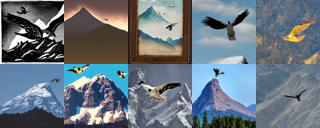

In [11]:
# 미세 조정 전의 이미지
img_list = pipe(["a mountain with a flying bird"]*10, num_inference_steps=25).images
image_grid([x.resize((64,64)) for x in img_list], 2,5)

In [ ]:
# import gc
# from numba import cuda
# del(pipe)
# gc.collect()
# torch.cuda.empty_cache()

In [ ]:
# https://godatadriven.com/blog/a-practical-guide-to-using-setup-py/
# run setup.py
# only run the first time
# !pip install -e .

## EuroSAT 데이터 세트에서 가져온 실제 고속도로 클래스 이미지

In [ ]:
# !accelerate launch scripts/train.py

In [12]:
from collections import defaultdict
import contextlib
import os
import datetime
from concurrent import futures
import time
from absl import app, flags
from ml_collections import config_flags
from accelerate import Accelerator
from accelerate.utils import set_seed, ProjectConfiguration
from accelerate.logging import get_logger
from diffusers import StableDiffusionPipeline, DDIMScheduler, UNet2DConditionModel
from diffusers.models.attention_processor import LoRAAttnProcessor
from diffusers.loaders import AttnProcsLayers
import numpy as np
import ddpo_pytorch.prompts
import ddpo_pytorch.rewards
from ddpo_pytorch.stat_tracking import PerPromptStatTracker
from ddpo_pytorch.diffusers_patch.pipeline_with_logprob import pipeline_with_logprob
from ddpo_pytorch.diffusers_patch.ddim_with_logprob import ddim_step_with_logprob
import torch
import wandb
from functools import partial
import tqdm
import tempfile
from PIL import Image

tqdm = partial(tqdm.tqdm, dynamic_ncols=True)


FLAGS = flags.FLAGS
config_flags.DEFINE_config_file("config", "ddpo_config/base.py", "Training configuration.")

logger = get_logger(__name__)



# # 기본적인 가속기 및 로깅 설정
# config = FLAGS.config
config = FLAGS['config'].value

unique_id = datetime.datetime.now().strftime("%Y.%m.%d_%H.%M.%S")
if not config.run_name:
    config.run_name = unique_id
else:
    config.run_name += "_" + unique_id

if config.resume_from:
    config.resume_from = os.path.normpath(os.path.expanduser(config.resume_from))
    if "checkpoint_" not in os.path.basename(config.resume_from):
        # 해당 경로에 최근 체크포인트 적재
        checkpoints = list(filter(lambda x: "checkpoint_" in x, os.listdir(config.resume_from)))
        if len(checkpoints) == 0:
            raise ValueError(f"No checkpoints found in {config.resume_from}")
        config.resume_from = os.path.join(
            config.resume_from,
            sorted(checkpoints, key=lambda x: int(x.split("_")[-1]))[-1],
        )

# 학습할 각 경로 내의 타임스텝 수
num_train_timesteps = int(config.sample.num_steps * config.train.timestep_fraction)

accelerator_config = ProjectConfiguration(
    project_dir=os.path.join(config.logdir, config.run_name),
    automatic_checkpoint_naming=True,
    total_limit=config.num_checkpoint_limit,
)

accelerator = Accelerator(
    # log_with="wandb",
    mixed_precision=config.mixed_precision,
    project_config=accelerator_config,
    # 우리는 항상 타임스텝에 따라 그래디언트를 누적합니다.
    # config.train.gradient_accumulation_steps은 그래디언트를 누적하려는 *샘플* 수가 되어야 하므로,
    # 학습 타임스텝 수를 곱해 전체 최적화 단계 수를 계산해야 합니다.
    gradient_accumulation_steps=config.train.gradient_accumulation_steps * num_train_timesteps,
)
if accelerator.is_main_process:
    accelerator.init_trackers(
        project_name="ddpo-pytorch", config=config.to_dict(), init_kwargs={"wandb": {"name": config.run_name}}
    )
logger.info(f"\n{config}")

# 시드 설정 (다른 장치에서 다른 프롬프트를 얻기 위해 device_specific이 매우 중요)
set_seed(config.seed, device_specific=True)

# 스케줄러, 토크나이저 및 모델 적재
pipeline = StableDiffusionPipeline.from_pretrained(config.pretrained.model, revision=config.pretrained.revision)
# 더 많은 메모리를 절약하기 위해 모델의 파라미터를 고정
pipeline.vae.requires_grad_(False)
pipeline.text_encoder.requires_grad_(False)
pipeline.unet.requires_grad_(not config.use_lora)
# 안전 검사기(safety checker)를 비활성화
pipeline.safety_checker = None
# 진행 표시줄을 더 보기 좋게 만들기
pipeline.set_progress_bar_config(
    position=1,
    disable=not accelerator.is_local_main_process,
    leave=False,
    desc="Timestep",
    dynamic_ncols=True,
)
# DDIM(Denoising Diffusion Implicit Models; DDIM) 스케줄러로 전환
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

# 혼합 정밀도로 학습하기 위해 모든 고정되는 가중치(변형 자동 인코더, 저순위 적응이 아닌 text_encoder와 저순위 적응(lora)이 아닌 U-Net)를 반 정밀도로 변환.
# 이러한 가중치는 추론에만 사용되므로, 완전 정밀도로 유지할 필요가 없습니다.
inference_dtype = torch.float32
if accelerator.mixed_precision == "fp16":
    inference_dtype = torch.float16
elif accelerator.mixed_precision == "bf16":
    inference_dtype = torch.bfloat16

# 변형 자동 인코더와 U-Net을 장치(device)에 불러서 weight_dtype로 변환.
pipeline.vae.to(accelerator.device, dtype=inference_dtype)
pipeline.text_encoder.to(accelerator.device, dtype=inference_dtype)
if config.use_lora:
    pipeline.unet.to(accelerator.device, dtype=inference_dtype)

if config.use_lora:
    # 올바른 저순위 적응 레이어를 설정
    lora_attn_procs = {}
    for name in pipeline.unet.attn_processors.keys():
        cross_attention_dim = (
            None if name.endswith("attn1.processor") else pipeline.unet.config.cross_attention_dim
        )
        if name.startswith("mid_block"):
            hidden_size = pipeline.unet.config.block_out_channels[-1]
        elif name.startswith("up_blocks"):
            block_id = int(name[len("up_blocks.")])
            hidden_size = list(reversed(pipeline.unet.config.block_out_channels))[block_id]
        elif name.startswith("down_blocks"):
            block_id = int(name[len("down_blocks.")])
            hidden_size = pipeline.unet.config.block_out_channels[block_id]

        lora_attn_procs[name] = LoRAAttnProcessor(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim)
    pipeline.unet.set_attn_processor(lora_attn_procs)
    trainable_layers = AttnProcsLayers(pipeline.unet.attn_processors)
else:
    trainable_layers = pipeline.unet

# 가속기를 활용해 확산 모델에 적합한 체크포인트 저장을 설정합니다.
def save_model_hook(models, weights, output_dir):
    assert len(models) == 1
    if config.use_lora and isinstance(models[0], AttnProcsLayers):
        pipeline.unet.save_attn_procs(output_dir)
    elif not config.use_lora and isinstance(models[0], UNet2DConditionModel):
        models[0].save_pretrained(os.path.join(output_dir, "unet"))
    else:
        raise ValueError(f"Unknown model type {type(models[0])}")
    weights.pop()  # 가속기가 모델 저장하지 않도록 합니다.

def load_model_hook(models, input_dir):
    assert len(models) == 1
    if config.use_lora and isinstance(models[0], AttnProcsLayers):
        # pipeline.unet.load_attn_procs(input_dir)
        tmp_unet = UNet2DConditionModel.from_pretrained(
            config.pretrained.model, revision=config.pretrained.revision, subfolder="unet"
        )
        tmp_unet.load_attn_procs(input_dir)
        models[0].load_state_dict(AttnProcsLayers(tmp_unet.attn_processors).state_dict())
        del tmp_unet
    elif not config.use_lora and isinstance(models[0], UNet2DConditionModel):
        load_model = UNet2DConditionModel.from_pretrained(input_dir, subfolder="unet")
        models[0].register_to_config(**load_model.config)
        models[0].load_state_dict(load_model.state_dict())
        del load_model
    else:
        raise ValueError(f"Unknown model type {type(models[0])}")
    models.pop()  # 가속기가 모델 저장하지 않도록 합니다.

accelerator.register_save_state_pre_hook(save_model_hook)
accelerator.register_load_state_pre_hook(load_model_hook)

# Ampere GPU로 더 빠른 학습을 위해 TF32를 활성화,
# 자세한 내용은 https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices를 참조
if config.allow_tf32:
    torch.backends.cuda.matmul.allow_tf32 = True

# 옵티마이저 초기화
if config.train.use_8bit_adam:
    try:
        import bitsandbytes as bnb
    except ImportError:
        raise ImportError(
            "Please install bitsandbytes to use 8-bit Adam. You can do so by running `pip install bitsandbytes`"
        )

    optimizer_cls = bnb.optim.AdamW8bit
else:
    optimizer_cls = torch.optim.AdamW

optimizer = optimizer_cls(
    trainable_layers.parameters(),
    lr=config.train.learning_rate,
    betas=(config.train.adam_beta1, config.train.adam_beta2),
    weight_decay=config.train.adam_weight_decay,
    eps=config.train.adam_epsilon,
)

# 프롬프트와 보상 함수 준비
prompt_fn = getattr(ddpo_pytorch.prompts, config.prompt_fn)
reward_fn = getattr(ddpo_pytorch.rewards, config.reward_fn)()

# 네거티브 프롬프트 임베딩 생성
neg_prompt_embed = pipeline.text_encoder(
    pipeline.tokenizer(
        [""],
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=pipeline.tokenizer.model_max_length,
    ).input_ids.to(accelerator.device)
)[0]
sample_neg_prompt_embeds = neg_prompt_embed.repeat(config.sample.batch_size, 1, 1)
train_neg_prompt_embeds = neg_prompt_embed.repeat(config.train.batch_size, 1, 1)

# 통계 추적기(stat tracker)를 초기화
if config.per_prompt_stat_tracking:
    stat_tracker = PerPromptStatTracker(
        config.per_prompt_stat_tracking.buffer_size,
        config.per_prompt_stat_tracking.min_count,
    )

# 어떤 이유든, 저순위 적응이 아닌 학습에는 오토케스트(autocast)가 필요하지만, 저순위 적응 학습에는 필요하지 않으며 더 많은 메모리를 사용합니다.
autocast = contextlib.nullcontext if config.use_lora else accelerator.autocast

# `가속기`로 모든 것을 준비합니다.
trainable_layers, optimizer = accelerator.prepare(trainable_layers, optimizer)


# 언어-이미지 시각 어시스턴트 콜백을 위해 원격 서버에 요청을 보내는 언어-이미지 시각 어시스턴트 추론을 수행할 때, 콜백을 비동기적으로 실행하는 실행기(executor)를 활용
executor = futures.ThreadPoolExecutor(max_workers=2)

# 학습 시작!
samples_per_epoch = config.sample.batch_size * accelerator.num_processes * config.sample.num_batches_per_epoch
total_train_batch_size = (
    config.train.batch_size * accelerator.num_processes * config.train.gradient_accumulation_steps
)

logger.info("***** Running training *****")
logger.info(f"  Num Epochs = {config.num_epochs}")
logger.info(f"  Sample batch size per device = {config.sample.batch_size}")
logger.info(f"  Train batch size per device = {config.train.batch_size}")
logger.info(f"  Gradient Accumulation steps = {config.train.gradient_accumulation_steps}")
logger.info("")
logger.info(f"  Total number of samples per epoch = {samples_per_epoch}")
logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_train_batch_size}")
logger.info(f"  Number of gradient updates per inner epoch = {samples_per_epoch // total_train_batch_size}")
logger.info(f"  Number of inner epochs = {config.train.num_inner_epochs}")

assert config.sample.batch_size >= config.train.batch_size
assert config.sample.batch_size % config.train.batch_size == 0
assert samples_per_epoch % total_train_batch_size == 0

if config.resume_from:
    logger.info(f"Resuming from {config.resume_from}")
    accelerator.load_state(config.resume_from)
    first_epoch = int(config.resume_from.split("_")[-1]) + 1
else:
    first_epoch = 0

global_step = 0
for epoch in range(first_epoch, config.num_epochs):
    #################### 샘플링 ####################
    pipeline.unet.eval()
    samples = []
    prompts = []
    for i in tqdm(
        range(config.sample.num_batches_per_epoch),
        desc=f"Epoch {epoch}: sampling",
        disable=not accelerator.is_local_main_process,
        position=0,
    ):
        # 프롬프트 생성
        prompts, prompt_metadata = zip(
            *[prompt_fn(**config.prompt_fn_kwargs) for _ in range(config.sample.batch_size)]
        )

        # 프롬프트 인코딩
        prompt_ids = pipeline.tokenizer(
            prompts,
            return_tensors="pt",
            padding="max_length",
            truncation=True,
            max_length=pipeline.tokenizer.model_max_length,
        ).input_ids.to(accelerator.device)
        prompt_embeds = pipeline.text_encoder(prompt_ids)[0]

        # 샘플
        with autocast():
            images, _, latents, log_probs = pipeline_with_logprob(
                pipeline,
                prompt_embeds=prompt_embeds,
                negative_prompt_embeds=sample_neg_prompt_embeds,
                num_inference_steps=config.sample.num_steps,
                guidance_scale=config.sample.guidance_scale,
                eta=config.sample.eta,
                output_type="pt",
            )

        latents = torch.stack(latents, dim=1)  # (batch_size, num_steps + 1, 4, 64, 64)
        log_probs = torch.stack(log_probs, dim=1)  # (batch_size, num_steps, 1)
        timesteps = pipeline.scheduler.timesteps.repeat(config.sample.batch_size, 1)  # (batch_size, num_steps)

        # 비동기적으로 보상 계산
        rewards = executor.submit(reward_fn, images, prompts, prompt_metadata)
        # 보상 계산이 시작되도록 대기(yield)
        time.sleep(0)

        samples.append(
            {
                "prompt_ids": prompt_ids,
                "prompt_embeds": prompt_embeds,
                "timesteps": timesteps,
                "latents": latents[:, :-1], # 각 항목은 타임스텝 t 이전의 잠재(latent)
                "next_latents": latents[:, 1:],  # 각 항목은 타임스텝 t 이후의 잠재
                "log_probs": log_probs,
                "rewards": rewards,
            }
        )

    # 모든 보상이 계산될 때까지 기다립니다.
    for sample in tqdm(
        samples,
        desc="Waiting for rewards",
        disable=not accelerator.is_local_main_process,
        position=0,
    ):
        rewards, reward_metadata = sample["rewards"].result()
        # accelerator.print(reward_metadata)
        sample["rewards"] = torch.as_tensor(rewards, device=accelerator.device)

    # 샘플들을 각 항목이 (num_batches_per_epoch * sample.batch_size, ...) 형태의 딕셔너리로 모읍니다.
    samples = {k: torch.cat([s[k] for s in samples]) for k in samples[0].keys()}

    # 프로세스 간에 보상을 모읍니다.
    rewards = accelerator.gather(samples["rewards"]).cpu().numpy()

    # 보상과 이미지를 로그에 기록
    accelerator.log(
        {"reward": rewards, "epoch": epoch, "reward_mean": rewards.mean(), "reward_std": rewards.std()},
        step=global_step,
    )

    # 출력
    print("reward = " + str(rewards))
    print("epoch = " + str(epoch))

    # 이것은 wandb가 이미지를 PNG 대신 JPEG 형식으로 기록하게 하기 위한 방법입니다.
    with tempfile.TemporaryDirectory() as tmpdir:
        for i, image in enumerate(images):
            pil = Image.fromarray((image.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))
            pil = pil.resize((256, 256))
            pil.save(os.path.join(tmpdir, f"{i}.jpg"))
        accelerator.log(
            {
                "images": [
                    wandb.Image(os.path.join(tmpdir, f"{i}.jpg"), caption=f"{prompt:.25} | {reward:.2f}")
                    for i, (prompt, reward) in enumerate(zip(prompts, rewards))
                ],
            },
            step=global_step,
        )

    # 프롬프트별 평균/포준편차 추적
    if config.per_prompt_stat_tracking:
        # 프로세스 간에 프롬프트를 수집합니다.
        prompt_ids = accelerator.gather(samples["prompt_ids"]).cpu().numpy()
        prompts = pipeline.tokenizer.batch_decode(prompt_ids, skip_special_tokens=True)
        advantages = stat_tracker.update(prompts, rewards)
    else:
        advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-8)

    # advantages을 수집 해제합니다; 이 프로세스의 샘플에 해당하는 항목만 유지하면 됩니다.
    samples["advantages"] = (
        torch.as_tensor(advantages)
        .reshape(accelerator.num_processes, -1)[accelerator.process_index]
        .to(accelerator.device)
    )

    del samples["rewards"]
    del samples["prompt_ids"]

    total_batch_size, num_timesteps = samples["timesteps"].shape
    assert total_batch_size == config.sample.batch_size * config.sample.num_batches_per_epoch
    assert num_timesteps == config.sample.num_steps

    #################### 학습 중 ####################
    for inner_epoch in range(config.train.num_inner_epochs):
        # 배치 차원에서 샘플을 섞습니다.
        perm = torch.randperm(total_batch_size, device=accelerator.device)
        samples = {k: v[perm] for k, v in samples.items()}

        # 각 샘플에 대해 시간 차원에서 독립적으로 섞습니다.
        perms = torch.stack(
            [torch.randperm(num_timesteps, device=accelerator.device) for _ in range(total_batch_size)]
        )
        for key in ["timesteps", "latents", "next_latents", "log_probs"]:
            samples[key] = samples[key][torch.arange(total_batch_size, device=accelerator.device)[:, None], perms]

        # 학습을 위해 재배치합니다.
        samples_batched = {k: v.reshape(-1, config.train.batch_size, *v.shape[1:]) for k, v in samples.items()}

        # 더 쉽게 반복할 수 있도록 리스트의 딕셔너리를 딕셔너리의 리스트로 변환
        samples_batched = [dict(zip(samples_batched, x)) for x in zip(*samples_batched.values())]

        # 학습
        pipeline.unet.train()
        info = defaultdict(list)
        for i, sample in tqdm(
            list(enumerate(samples_batched)),
            desc=f"Epoch {epoch}.{inner_epoch}: training",
            position=0,
            disable=not accelerator.is_local_main_process,
        ):
            if config.train.cfg:
                # 두 번의 순전파 전달를 피하기 위해 샘플 프롬프트에 네거티브 프롬프트를 결합합니다.
                embeds = torch.cat([train_neg_prompt_embeds, sample["prompt_embeds"]])
            else:
                embeds = sample["prompt_embeds"]

            for j in tqdm(
                range(num_train_timesteps),
                desc="Timestep",
                position=1,
                leave=False,
                disable=not accelerator.is_local_main_process,
            ):
                with accelerator.accumulate(pipeline.unet):
                    with autocast():
                        if config.train.cfg:
                            noise_pred = pipeline.unet(
                                torch.cat([sample["latents"][:, j]] * 2),
                                torch.cat([sample["timesteps"][:, j]] * 2),
                                embeds,
                            ).sample
                            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
                            noise_pred = noise_pred_uncond + config.sample.guidance_scale * (
                                noise_pred_text - noise_pred_uncond
                            )
                        else:
                            noise_pred = pipeline.unet(
                                sample["latents"][:, j], sample["timesteps"][:, j], embeds
                            ).sample
                        # 현재 모델에서 latent로부터 next_latents의 로그 확률을 계산합니다.
                        _, log_prob = ddim_step_with_logprob(
                            pipeline.scheduler,
                            noise_pred,
                            sample["timesteps"][:, j],
                            sample["latents"][:, j],
                            eta=config.sample.eta,
                            prev_sample=sample["next_latents"][:, j],
                        )

                    # 근접 정책 최적화(ppo) 로짓값
                    advantages = torch.clamp(
                        sample["advantages"], -config.train.adv_clip_max, config.train.adv_clip_max
                    )
                    ratio = torch.exp(log_prob - sample["log_probs"][:, j])
                    unclipped_loss = -advantages * ratio
                    clipped_loss = -advantages * torch.clamp(
                        ratio, 1.0 - config.train.clip_range, 1.0 + config.train.clip_range
                    )
                    loss = torch.mean(torch.maximum(unclipped_loss, clipped_loss))

                    # 디버깅 값
                    # John Schulman은 (ratio - 1) - log(ratio)가 더 나은 추정치라고 하지만, 대부분의 기존 코드는 이것을 사용합니다....
                    # http://joschu.net/blog/kl-approx.html
                    info["approx_kl"].append(0.5 * torch.mean((log_prob - sample["log_probs"][:, j]) ** 2))
                    info["clipfrac"].append(torch.mean((torch.abs(ratio - 1.0) > config.train.clip_range).float()))
                    info["loss"].append(loss)

                    # 역전파 전달
                    accelerator.backward(loss)
                    if accelerator.sync_gradients:
                        accelerator.clip_grad_norm_(trainable_layers.parameters(), config.train.max_grad_norm)
                    optimizer.step()
                    optimizer.zero_grad()

                # 가속기가 뒤에서 최적화 단계를 수행했는지 확인
                if accelerator.sync_gradients:
                    assert (j == num_train_timesteps - 1) and (
                        i + 1
                    ) % config.train.gradient_accumulation_steps == 0
                    # 학습과 관련된 항목을 로깅
                    info = {k: torch.mean(torch.stack(v)) for k, v in info.items()}
                    info = accelerator.reduce(info, reduction="mean")
                    info.update({"epoch": epoch, "inner_epoch": inner_epoch})
                    accelerator.log(info, step=global_step)
                    global_step += 1
                    info = defaultdict(list)

        # 내부 에포크가 끝날 때 최적화 단계가 완료됐는지 확인
        assert accelerator.sync_gradients

    if epoch > 0 and epoch % config.save_freq == 0 and accelerator.is_main_process:
        accelerator.save_state()

# save_model_hook()을 따라 업데이트된 저순위 적응 가중치만 저장
output_dir = os.path.join(config.out_dir, config.run_name)
if config.use_lora:
    pipeline.unet.save_attn_procs(output_dir)
elif not config.use_lora:
    pipeline.save_pretrained(output_dir, variant="fp16")
else:
    raise ValueError(f"Unknown model type to save.")


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:488: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
Epoch 0: sampling:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:237: FutureWarning: `_encode_prompt()` is deprecated and it will be removed in a future version. Use `encode_prompt()` instead. Also, be aware that the output format changed from a concatenated tensor to a tuple.
  deprecate("_encode_prompt()", "1.0.0", deprecation_message, standard_warn=False)


Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/diffusers/models/attention_processor.py:1405: FutureWarning: `LoRAAttnProcessor` is deprecated and will be removed in version 0.26.0. Make sure use AttnProcessor instead by settingLoRA layers to `self.{to_q,to_k,to_v,to_out[0]}.lora_layer` respectively. This will be done automatically when using `LoraLoaderMixin.load_lora_weights`
  deprecate(
Epoch 0: sampling:  50%|█████     | 1/2 [00:11<00:11, 11.04s/it]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Waiting for rewards: 100%|██████████| 2/2 [00:00<00:00, 12.58it/s]


reward = [10 16]
epoch = 0


Epoch 1: sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 1: sampling:  50%|█████     | 1/2 [00:10<00:10, 10.67s/it]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Waiting for rewards: 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]


reward = [-7 11]
epoch = 1


Epoch 2: sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 2: sampling:  50%|█████     | 1/2 [00:10<00:10, 10.93s/it]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Waiting for rewards: 100%|██████████| 2/2 [00:00<00:00, 11.25it/s]


reward = [-10  13]
epoch = 2


Epoch 3: sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 3: sampling:  50%|█████     | 1/2 [00:11<00:11, 11.11s/it]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Waiting for rewards: 100%|██████████| 2/2 [00:00<00:00, 10.83it/s]


reward = [ 0 -5]
epoch = 3


Epoch 4: sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 4: sampling:  50%|█████     | 1/2 [00:11<00:11, 11.14s/it]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Waiting for rewards: 100%|██████████| 2/2 [00:00<00:00, 11.05it/s]


reward = [-18 -12]
epoch = 4


Epoch 5: sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 5: sampling:  50%|█████     | 1/2 [00:11<00:11, 11.02s/it]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Waiting for rewards: 100%|██████████| 2/2 [00:00<00:00, 11.29it/s]


reward = [ 4 -2]
epoch = 5


Epoch 6: sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 6: sampling:  50%|█████     | 1/2 [00:11<00:11, 11.09s/it]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Waiting for rewards: 100%|██████████| 2/2 [00:00<00:00, 11.45it/s]


reward = [ 9 -1]
epoch = 6


Epoch 7: sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 7: sampling:  50%|█████     | 1/2 [00:11<00:11, 11.11s/it]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Waiting for rewards: 100%|██████████| 2/2 [00:00<00:00, 11.69it/s]


reward = [-12  -5]
epoch = 7


Epoch 8: sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 8: sampling:  50%|█████     | 1/2 [00:11<00:11, 11.16s/it]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Waiting for rewards: 100%|██████████| 2/2 [00:00<00:00, 11.58it/s]


reward = [ 19 -18]
epoch = 8


Epoch 9: sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch 9: sampling:  50%|█████     | 1/2 [00:11<00:11, 11.27s/it]

Timestep:   0%|          | 0/50 [00:00<?, ?it/s]

Waiting for rewards: 100%|██████████| 2/2 [00:00<00:00, 11.39it/s]


reward = [-5 -8]
epoch = 9


Epoch 9.0: training: 100%|██████████| 2/2 [00:49<00:00, 24.62s/it]


In [ ]:
# from collections import defaultdict
# import contextlib
# import os
# import datetime
# from concurrent import futures
# import time
# from absl import app, flags
# from ml_collections import config_flags
# from accelerate import Accelerator
# from accelerate.utils import set_seed, ProjectConfiguration
# from accelerate.logging import get_logger
# from diffusers import StableDiffusionPipeline, DDIMScheduler, UNet2DConditionModel
# from diffusers.loaders import AttnProcsLayers
# from diffusers.models.attention_processor import LoRAAttnProcessor
# import numpy as np
# import ddpo_pytorch.prompts
# import ddpo_pytorch.rewards
# from ddpo_pytorch.stat_tracking import PerPromptStatTracker
# from ddpo_pytorch.diffusers_patch.pipeline_with_logprob import pipeline_with_logprob
# from ddpo_pytorch.diffusers_patch.ddim_with_logprob import ddim_step_with_logprob
# import torch
# import wandb
# from functools import partial
# import tqdm
# import tempfile
# from PIL import Image
# import boto3
# import json

# tqdm = partial(tqdm.tqdm, dynamic_ncols=True)


# FLAGS = flags.FLAGS
# config_flags.DEFINE_config_file("config", "ddpo_config/base.py", "Training configuration.")

# logger = get_logger(__name__)


# # basic Accelerate and logging setup
# config = FLAGS.config

# unique_id = datetime.datetime.now().strftime("%Y.%m.%d_%H.%M.%S")
# if not config.run_name:
#     config.run_name = unique_id
# else:
#     config.run_name += "_" + unique_id

# if config.resume_from:
#     config.resume_from = os.path.normpath(os.path.expanduser(config.resume_from))
#     if "checkpoint_" not in os.path.basename(config.resume_from):
#         # get the most recent checkpoint in this directory
#         checkpoints = list(filter(lambda x: "checkpoint_" in x, os.listdir(config.resume_from)))
#         if len(checkpoints) == 0:
#             raise ValueError(f"No checkpoints found in {config.resume_from}")
#         config.resume_from = os.path.join(
#             config.resume_from,
#             sorted(checkpoints, key=lambda x: int(x.split("_")[-1]))[-1],
#         )

# # number of timesteps within each trajectory to train on
# num_train_timesteps = int(config.sample.num_steps * config.train.timestep_fraction)

# accelerator_config = ProjectConfiguration(
#     project_dir=os.path.join(config.logdir, config.run_name),
#     automatic_checkpoint_naming=True,
#     total_limit=config.num_checkpoint_limit,
# )

# accelerator = Accelerator(
#     # log_with="wandb",
#     mixed_precision=config.mixed_precision,
#     project_config=accelerator_config,
#     # we always accumulate gradients across timesteps; we want config.train.gradient_accumulation_steps to be the
#     # number of *samples* we accumulate across, so we need to multiply by the number of training timesteps to get
#     # the total number of optimizer steps to accumulate across.
#     gradient_accumulation_steps=config.train.gradient_accumulation_steps * num_train_timesteps,
# )
# if accelerator.is_main_process:
#     accelerator.init_trackers(
#         project_name="ddpo-pytorch", config=config.to_dict(), init_kwargs={"wandb": {"name": config.run_name}}
#     )
# logger.info(f"\n{config}")

# # set seed (device_specific is very important to get different prompts on different devices)
# set_seed(config.seed, device_specific=True)

# # load scheduler, tokenizer and models.
# pipeline = StableDiffusionPipeline.from_pretrained(config.pretrained.model, revision=config.pretrained.revision)
# # freeze parameters of models to save more memory
# pipeline.vae.requires_grad_(False)
# pipeline.text_encoder.requires_grad_(False)
# pipeline.unet.requires_grad_(not config.use_lora)
# # disable safety checker
# pipeline.safety_checker = None
# # make the progress bar nicer
# pipeline.set_progress_bar_config(
#     position=1,
#     disable=not accelerator.is_local_main_process,
#     leave=False,
#     desc="Timestep",
#     dynamic_ncols=True,
# )
# # switch to DDIM scheduler
# pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)

# # For mixed precision training we cast all non-trainable weigths (vae, non-lora text_encoder and non-lora unet) to half-precision
# # as these weights are only used for inference, keeping weights in full precision is not required.
# inference_dtype = torch.float32
# if accelerator.mixed_precision == "fp16":
#     inference_dtype = torch.float16
# elif accelerator.mixed_precision == "bf16":
#     inference_dtype = torch.bfloat16

# # Move unet, vae and text_encoder to device and cast to inference_dtype
# pipeline.vae.to(accelerator.device, dtype=inference_dtype)
# pipeline.text_encoder.to(accelerator.device, dtype=inference_dtype)
# if config.use_lora:
#     pipeline.unet.to(accelerator.device, dtype=inference_dtype)

# if config.use_lora:
#     # Set correct lora layers
#     lora_attn_procs = {}
#     for name in pipeline.unet.attn_processors.keys():
#         cross_attention_dim = (
#             None if name.endswith("attn1.processor") else pipeline.unet.config.cross_attention_dim
#         )
#         if name.startswith("mid_block"):
#             hidden_size = pipeline.unet.config.block_out_channels[-1]
#         elif name.startswith("up_blocks"):
#             block_id = int(name[len("up_blocks.")])
#             hidden_size = list(reversed(pipeline.unet.config.block_out_channels))[block_id]
#         elif name.startswith("down_blocks"):
#             block_id = int(name[len("down_blocks.")])
#             hidden_size = pipeline.unet.config.block_out_channels[block_id]

#         lora_attn_procs[name] = LoRAAttnProcessor(hidden_size=hidden_size, cross_attention_dim=cross_attention_dim)
#     pipeline.unet.set_attn_processor(lora_attn_procs)
#     trainable_layers = AttnProcsLayers(pipeline.unet.attn_processors)
# else:
#     trainable_layers = pipeline.unet

# # set up diffusers-friendly checkpoint saving with Accelerate
# def save_model_hook(models, weights, output_dir):
#     assert len(models) == 1
#     if config.use_lora and isinstance(models[0], AttnProcsLayers):
#         pipeline.unet.save_attn_procs(output_dir)
#     elif not config.use_lora and isinstance(models[0], UNet2DConditionModel):
#         models[0].save_pretrained(os.path.join(output_dir, "unet"))
#     else:
#         raise ValueError(f"Unknown model type {type(models[0])}")
#     weights.pop()  # ensures that accelerate doesn't try to handle saving of the model

# def load_model_hook(models, input_dir):
#     assert len(models) == 1
#     if config.use_lora and isinstance(models[0], AttnProcsLayers):
#         # pipeline.unet.load_attn_procs(input_dir)
#         tmp_unet = UNet2DConditionModel.from_pretrained(
#             config.pretrained.model, revision=config.pretrained.revision, subfolder="unet"
#         )
#         tmp_unet.load_attn_procs(input_dir)
#         models[0].load_state_dict(AttnProcsLayers(tmp_unet.attn_processors).state_dict())
#         del tmp_unet
#     elif not config.use_lora and isinstance(models[0], UNet2DConditionModel):
#         load_model = UNet2DConditionModel.from_pretrained(input_dir, subfolder="unet")
#         models[0].register_to_config(**load_model.config)
#         models[0].load_state_dict(load_model.state_dict())
#         del load_model
#     else:
#         raise ValueError(f"Unknown model type {type(models[0])}")
#     models.pop()  # ensures that accelerate doesn't try to handle loading of the model

# accelerator.register_save_state_pre_hook(save_model_hook)
# accelerator.register_load_state_pre_hook(load_model_hook)

# # Enable TF32 for faster training on Ampere GPUs,
# # cf https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
# if config.allow_tf32:
#     torch.backends.cuda.matmul.allow_tf32 = True

# # Initialize the optimizer
# if config.train.use_8bit_adam:
#     try:
#         import bitsandbytes as bnb
#     except ImportError:
#         raise ImportError(
#             "Please install bitsandbytes to use 8-bit Adam. You can do so by running `pip install bitsandbytes`"
#         )

#     optimizer_cls = bnb.optim.AdamW8bit
# else:
#     optimizer_cls = torch.optim.AdamW

# optimizer = optimizer_cls(
#     trainable_layers.parameters(),
#     lr=config.train.learning_rate,
#     betas=(config.train.adam_beta1, config.train.adam_beta2),
#     weight_decay=config.train.adam_weight_decay,
#     eps=config.train.adam_epsilon,
# )

# # prepare prompt and reward fn
# prompt_fn = getattr(ddpo_pytorch.prompts, config.prompt_fn)
# reward_fn = getattr(ddpo_pytorch.rewards, config.reward_fn)()

# # generate negative prompt embeddings
# neg_prompt_embed = pipeline.text_encoder(
#     pipeline.tokenizer(
#         [""],
#         return_tensors="pt",
#         padding="max_length",
#         truncation=True,
#         max_length=pipeline.tokenizer.model_max_length,
#     ).input_ids.to(accelerator.device)
# )[0]
# sample_neg_prompt_embeds = neg_prompt_embed.repeat(config.sample.batch_size, 1, 1)
# train_neg_prompt_embeds = neg_prompt_embed.repeat(config.train.batch_size, 1, 1)

# # initialize stat tracker
# if config.per_prompt_stat_tracking:
#     stat_tracker = PerPromptStatTracker(
#         config.per_prompt_stat_tracking.buffer_size,
#         config.per_prompt_stat_tracking.min_count,
#     )

# # for some reason, autocast is necessary for non-lora training but for lora training it isn't necessary and it uses
# # more memory
# autocast = contextlib.nullcontext if config.use_lora else accelerator.autocast

# # Prepare everything with our `accelerator`.
# trainable_layers, optimizer = accelerator.prepare(trainable_layers, optimizer)

# # executor to perform callbacks asynchronously. this is beneficial for the llava callbacks which makes a request to a
# # remote server running llava inference.
# executor = futures.ThreadPoolExecutor(max_workers=2)

# # Train!
# samples_per_epoch = config.sample.batch_size * accelerator.num_processes * config.sample.num_batches_per_epoch
# total_train_batch_size = (
#     config.train.batch_size * accelerator.num_processes * config.train.gradient_accumulation_steps
# )

# logger.info("***** Running training *****")
# logger.info(f"  Num Epochs = {config.num_epochs}")
# logger.info(f"  Sample batch size per device = {config.sample.batch_size}")
# logger.info(f"  Train batch size per device = {config.train.batch_size}")
# logger.info(f"  Gradient Accumulation steps = {config.train.gradient_accumulation_steps}")
# logger.info("")
# logger.info(f"  Total number of samples per epoch = {samples_per_epoch}")
# logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_train_batch_size}")
# logger.info(f"  Number of gradient updates per inner epoch = {samples_per_epoch // total_train_batch_size}")
# logger.info(f"  Number of inner epochs = {config.train.num_inner_epochs}")

# assert config.sample.batch_size >= config.train.batch_size
# assert config.sample.batch_size % config.train.batch_size == 0
# assert samples_per_epoch % total_train_batch_size == 0

# if config.resume_from:
#     logger.info(f"Resuming from {config.resume_from}")
#     accelerator.load_state(config.resume_from)
#     first_epoch = int(config.resume_from.split("_")[-1]) + 1
# else:
#     first_epoch = 0

# sns_topic_arn = config.sns_topic_arn
# sns_client = boto3.client('sns')

# reward_sqs_name = config.sqs_name
# sqs_region = config.sqs_region
# sqs_client = boto3.client('sqs', region_name=sqs_region)
# sqs_client.create_queue(QueueName=reward_sqs_name)
# sqs_obj = boto3.resource('sqs', region_name=sqs_region)
# sqs_queue = sqs_obj.get_queue_by_name(QueueName=reward_sqs_name)
# sqs_url = sqs_client.get_queue_url(QueueName=reward_sqs_name)['QueueUrl']

# global_step = 0
# image_global_order = 0  # use to map rewards to corresponding images
# for epoch in range(first_epoch, config.num_epochs):
#     #################### SAMPLING ####################
#     pipeline.unet.eval()
#     samples = []
#     prompts = []
#     for i in tqdm(
#         range(config.sample.num_batches_per_epoch),
#         desc=f"Epoch {epoch}: sampling",
#         disable=not accelerator.is_local_main_process,
#         position=0,
#     ):
#         # generate prompts
#         prompts, prompt_metadata = zip(
#             *[prompt_fn(**config.prompt_fn_kwargs) for _ in range(config.sample.batch_size)]
#         )

#         # encode prompts
#         prompt_ids = pipeline.tokenizer(
#             prompts,
#             return_tensors="pt",
#             padding="max_length",
#             truncation=True,
#             max_length=pipeline.tokenizer.model_max_length,
#         ).input_ids.to(accelerator.device)
#         prompt_embeds = pipeline.text_encoder(prompt_ids)[0]

#         # sample
#         with autocast():
#             images, _, latents, log_probs = pipeline_with_logprob(
#                 pipeline,
#                 prompt_embeds=prompt_embeds,
#                 negative_prompt_embeds=sample_neg_prompt_embeds,
#                 num_inference_steps=config.sample.num_steps,
#                 guidance_scale=config.sample.guidance_scale,
#                 eta=config.sample.eta,
#                 output_type="pt",
#             )

#         latents = torch.stack(latents, dim=1)  # (batch_size, num_steps + 1, 4, 64, 64)
#         log_probs = torch.stack(log_probs, dim=1)  # (batch_size, num_steps, 1)
#         timesteps = pipeline.scheduler.timesteps.repeat(config.sample.batch_size, 1)  # (batch_size, num_steps)

# #             #########################################################################
#         # compute rewards asynchronously
#         # rewards = executor.submit(reward_fn, images, prompts, prompt_metadata)
#         # # yield to to make sure reward computation starts
#         # time.sleep(0)
# #             ##########################################################################

#         samples.append(
#             {
#                 "prompt_ids": prompt_ids,
#                 "prompt_embeds": prompt_embeds,
#                 "timesteps": timesteps,
#                 "latents": latents[:, :-1],  # each entry is the latent before timestep t
#                 "next_latents": latents[:, 1:],  # each entry is the latent after timestep t
#                 "log_probs": log_probs,
#                 # "rewards": rewards # important to update rewards later
#             }
#         )

#         # save image to a directory
#         images_dir = config.image_dir
#         for image_index, image in enumerate(images):
#             pil = Image.fromarray((image.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))
#             pil = pil.resize((256, 256))
#             # i = batch
#             pil.save(os.path.join(images_dir, f"{image_global_order}_{epoch}.{i}.{image_index}.jpg"))
#             print("\nsaved image: " + f"{image_global_order}_{epoch}.{i}.{image_index}.jpg" + "\n")
#             image_global_order = image_global_order + 1

#         # print("\nlen(images) = " + str(len(images)) + "\n")

#     ####################### Ground Truth Rewards #########################

#     # send sns nodifications for reward labelling
#     message = "Label rewards at epoch = " + str(epoch)
#     msg_body = json.dumps(message)

#     sns_client.publish(
#             TopicArn=sns_topic_arn,
#             Message=json.dumps({'default': msg_body}),
#             MessageStructure='json')
#     print("\nSNS published message: " + str(message))

#     # loop to wait sqs messages for returnning rewards
#     rewards_gt = None
#     loop = True
#     while (loop):
#             sqs_msgs = sqs_queue.receive_messages(
#                                 AttributeNames=['All'],
#                                 MessageAttributeNames=['All'],
#                                 VisibilityTimeout=15,
#                                 WaitTimeSeconds=20,
#                                 MaxNumberOfMessages=5
#                         )

#             if len(sqs_msgs)>0:
#                 loop = False
#                 for msg in sqs_msgs:
#                     msg_body = msg.body
#                     rewards_gt = json.loads(msg_body)
#                     print("\nReceive SQS message with labelled rewards: " + str(rewards_gt) + "\n")

#                 # delete the received messages
#                 for msg in sqs_msgs:
#                     sqs_client.delete_message(QueueUrl=sqs_url,
#                                               ReceiptHandle=msg.receipt_handle)
#             else:
#                 time.sleep(10)

#     # print("rewards_gt = " + str(rewards_gt))

# #         # wait for all rewards to be computed
#     # for sample in tqdm(
#     #     samples,
#     #     desc="Waiting for rewards",
#     #     disable=not accelerator.is_local_main_process,
#     #     position=0,
#     # ):
#     #     rewards, reward_metadata = sample["rewards"].result()
#     #     # accelerator.print(reward_metadata)
#     #     sample["rewards"] = torch.as_tensor(rewards, device=accelerator.device)
#     #     # rewards is a numpy array
#     #     print("\n1: rewards = " + str(rewards))

#     # collate samples into dict where each entry has shape (num_batches_per_epoch * sample.batch_size, ...)
#     # for example, 2 samples, len(samples) == 2, where each sample has 7 key-value pairs
#     # is converted to 7 keys where each sample is a value
#     samples = {k: torch.cat([s[k] for s in samples]) for k in samples[0].keys()}

#     # map ground truth rewards to samples, sample["rewards"]
#     rewards = rewards_gt

# #         # gather rewards across processes
#     # rewards = accelerator.gather(samples["rewards"]).cpu().numpy()

# #         # log rewards and images
# #         accelerator.log(
# #             {"reward": rewards, "epoch": epoch, "reward_mean": rewards.mean(), "reward_std": rewards.std()},
# #             step=global_step,
# #         )

#     # print out
#     print("rewards = " + str(rewards))
#     print("epoch = " + str(epoch))

#     # # this is a hack to force wandb to log the images as JPEGs instead of PNGs
#     # with tempfile.TemporaryDirectory() as tmpdir:
#     #     for i, image in enumerate(images):
#     #         pil = Image.fromarray((image.cpu().numpy().transpose(1, 2, 0) * 255).astype(np.uint8))
#     #         pil = pil.resize((256, 256))
#     #         pil.save(os.path.join(tmpdir, f"{i}.jpg"))
#     #     accelerator.log(
#     #         {
#     #             "images": [
#     #                 wandb.Image(os.path.join(tmpdir, f"{i}.jpg"), caption=f"{prompt:.25} | {reward:.2f}")
#     #                 for i, (prompt, reward) in enumerate(zip(prompts, rewards))
#     #             ],
#     #         },
#     #         step=global_step,
#     #     )

#     # per-prompt mean/std tracking
#     if config.per_prompt_stat_tracking:
#         # gather the prompts across processes
#         prompt_ids = accelerator.gather(samples["prompt_ids"]).cpu().numpy()
#         prompts = pipeline.tokenizer.batch_decode(prompt_ids, skip_special_tokens=True)
#         # prompts needs to have the same dimension as rewards here.
#         # hence num_images_per_prompt must be 1
#         advantages = stat_tracker.update(prompts, rewards)
#     else:
#         advantages = (rewards - rewards.mean()) / (rewards.std() + 1e-8)

#     # ungather advantages; we only need to keep the entries corresponding to the samples on this process
#     samples["advantages"] = (
#         torch.as_tensor(advantages)
#         .reshape(accelerator.num_processes, -1)[accelerator.process_index]
#         .to(accelerator.device)
#     )

#     # del samples["rewards"]
#     del samples["prompt_ids"]

#     total_batch_size, num_timesteps = samples["timesteps"].shape
#     assert total_batch_size == config.sample.batch_size * config.sample.num_batches_per_epoch
#     assert num_timesteps == config.sample.num_steps

#     #################### TRAINING ####################
#     for inner_epoch in range(config.train.num_inner_epochs):
#         # shuffle samples along batch dimension
#         perm = torch.randperm(total_batch_size, device=accelerator.device)
#         samples = {k: v[perm] for k, v in samples.items()}

#         # shuffle along time dimension independently for each sample
#         perms = torch.stack(
#             [torch.randperm(num_timesteps, device=accelerator.device) for _ in range(total_batch_size)]
#         )
#         for key in ["timesteps", "latents", "next_latents", "log_probs"]:
#             samples[key] = samples[key][torch.arange(total_batch_size, device=accelerator.device)[:, None], perms]

#         # rebatch for training
#         samples_batched = {k: v.reshape(-1, config.train.batch_size, *v.shape[1:]) for k, v in samples.items()}

#         # dict of lists -> list of dicts for easier iteration
#         samples_batched = [dict(zip(samples_batched, x)) for x in zip(*samples_batched.values())]

#         # train
#         pipeline.unet.train()
#         info = defaultdict(list)
#         for i, sample in tqdm(
#             list(enumerate(samples_batched)),
#             desc=f"Epoch {epoch}.{inner_epoch}: training",
#             position=0,
#             disable=not accelerator.is_local_main_process,
#         ):
#             if config.train.cfg:
#                 # concat negative prompts to sample prompts to avoid two forward passes
#                 embeds = torch.cat([train_neg_prompt_embeds, sample["prompt_embeds"]])
#             else:
#                 embeds = sample["prompt_embeds"]

#             for j in tqdm(
#                 range(num_train_timesteps),
#                 desc="Timestep",
#                 position=1,
#                 leave=False,
#                 disable=not accelerator.is_local_main_process,
#             ):
#                 with accelerator.accumulate(pipeline.unet):
#                     with autocast():
#                         if config.train.cfg:
#                             noise_pred = pipeline.unet(
#                                 torch.cat([sample["latents"][:, j]] * 2),
#                                 torch.cat([sample["timesteps"][:, j]] * 2),
#                                 embeds,
#                             ).sample
#                             noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
#                             noise_pred = noise_pred_uncond + config.sample.guidance_scale * (
#                                 noise_pred_text - noise_pred_uncond
#                             )
#                         else:
#                             noise_pred = pipeline.unet(
#                                 sample["latents"][:, j], sample["timesteps"][:, j], embeds
#                             ).sample
#                         # compute the log prob of next_latents given latents under the current model
#                         _, log_prob = ddim_step_with_logprob(
#                             pipeline.scheduler,
#                             noise_pred,
#                             sample["timesteps"][:, j],
#                             sample["latents"][:, j],
#                             eta=config.sample.eta,
#                             prev_sample=sample["next_latents"][:, j],
#                         )

#                     # ppo logic
#                     advantages = torch.clamp(
#                         sample["advantages"], -config.train.adv_clip_max, config.train.adv_clip_max
#                     )
#                     ratio = torch.exp(log_prob - sample["log_probs"][:, j])
#                     unclipped_loss = -advantages * ratio
#                     clipped_loss = -advantages * torch.clamp(
#                         ratio, 1.0 - config.train.clip_range, 1.0 + config.train.clip_range
#                     )
#                     loss = torch.mean(torch.maximum(unclipped_loss, clipped_loss))

#                     # debugging values
#                     # John Schulman says that (ratio - 1) - log(ratio) is a better
#                     # estimator, but most existing code uses this so...
#                     # http://joschu.net/blog/kl-approx.html
#                     info["approx_kl"].append(0.5 * torch.mean((log_prob - sample["log_probs"][:, j]) ** 2))
#                     info["clipfrac"].append(torch.mean((torch.abs(ratio - 1.0) > config.train.clip_range).float()))
#                     info["loss"].append(loss)

#                     # backward pass
#                     accelerator.backward(loss)
#                     if accelerator.sync_gradients:
#                         accelerator.clip_grad_norm_(trainable_layers.parameters(), config.train.max_grad_norm)
#                     optimizer.step()
#                     optimizer.zero_grad()

#                 # Checks if the accelerator has performed an optimization step behind the scenes
#                 if accelerator.sync_gradients:
#                     assert (j == num_train_timesteps - 1) and (
#                         i + 1
#                     ) % config.train.gradient_accumulation_steps == 0
#                     # log training-related stuff
#                     info = {k: torch.mean(torch.stack(v)) for k, v in info.items()}
#                     info = accelerator.reduce(info, reduction="mean")
#                     info.update({"epoch": epoch, "inner_epoch": inner_epoch})
#                     accelerator.log(info, step=global_step)
#                     global_step += 1
#                     info = defaultdict(list)

#         # make sure we did an optimization step at the end of the inner epoch
#         assert accelerator.sync_gradients

#     if epoch > 0 and epoch % config.save_freq == 0 and accelerator.is_main_process:
#         accelerator.save_state()

# # follow save_model_hook() to save only lora weights that are updatd
# output_dir = os.path.join(config.out_dir, config.run_name)
# if config.use_lora:
#     pipeline.unet.save_attn_procs(output_dir)
# elif not config.use_lora:
#     pipeline.save_pretrained(output_dir, variant="fp16")
# else:
#     raise ValueError(f"Unknown model type to save.")
# print("Saved lora model to " + str(output_dir))


In [35]:
from diffusers import DiffusionPipeline, DPMSolverMultistepScheduler
import torch

pipe = DiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe.to("cuda")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


StableDiffusionPipeline {
  "_class_name": "StableDiffusionPipeline",
  "_diffusers_version": "0.21.0",
  "_name_or_path": "runwayml/stable-diffusion-v1-5",
  "feature_extractor": [
    "transformers",
    "CLIPImageProcessor"
  ],
  "requires_safety_checker": true,
  "safety_checker": [
    "stable_diffusion",
    "StableDiffusionSafetyChecker"
  ],
  "scheduler": [
    "diffusers",
    "DPMSolverMultistepScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

In [36]:
import glob
# 가장 최근에 생성된 모델 체크포인트 적재
dir_list = [os.path.join("./trained_model", folder) for folder in os.listdir("./trained_model")]
latest_edit = max(dir_list, key=os.path.getmtime)

pipe.unet.load_attn_procs(latest_edit)

  0%|          | 0/25 [00:00<?, ?it/s]

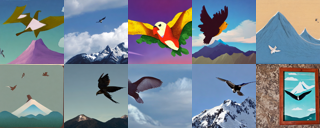

In [37]:
img_list = pipe(["a mountain with a flying bird"]*10, num_inference_steps=25).images
image_grid([x.resize((64,64)) for x in img_list], 2,5)

In [38]:
# img_list = pipe(["antique building"]*10, num_inference_steps=25).images
# image_grid([x.resize((64,64)) for x in img_list], 2,5)

In [39]:
import gc

del(pipe)
gc.collect()
torch.cuda.empty_cache()

색상과 스타일 면에서 스테이블 디퓨전으로 직접 생성한 이미지와 실제 EuroSAT 데이터 세트 이미지 사이에 상당한 차이가 있음을 알 수 있습니다.

## LORA와 드림부스를 활용한 스테이블 디퓨전 미세 조정
텍스트-이미지 모델을 미세 조정해 올바른 유형의 위성 이미지를 생성하는 방법을 학습시키고자 합니다. 이를 위해 최근의 두 가지 혁신적인 기술인 드림부스와 LoRA를 활용합니다. 드림부스는 모델이 더 큰 `class`에 비해 `instance`의 고유한 특성에 맞는 이미지를 생성하는 법을 학습할 수 있게 해주는 새로운 방법입니다. 저순위 어댑터(LoRA)는 학습 매개변수의 수를 대폭 줄임으로써 빠른 모델 학습을 가능하게 합니다. [여기](https://github.com/huggingface/diffusers/blob/main/examples/dreambooth/README.md)에서 찾을 수 있는 스크립트를 활용합니다.

스테이블 디퓨전이 새로운 `instance`를 학습하게 하려면, 새로운 `instance`를 나타내는 고유하고 짧은 토큰이나 단어를 사용합니다. 이때 다른 의미 있는 단어와 문자 순서가 유사하지 않은 토큰 `sks`를 사용합니다. `sks`는 스테이블 디퓨전 미세 조정을 위한 여러 튜토리얼에서 일반적으로 사용됩니다.

먼저 diffusers 라이브러리를 설치합니다.

다음으로 미세 조정 코드를 실행합니다. 이는 노트북의 instance 내에서 로컬로 미세 조정을 실행합니다. [accelerate](https://github.com/huggingface/accelerate) 라이브러리는 다중 GPU에서 파이토치 코드를 쉽게 실행할 수 있게 해줍니다.

## 결과 시각화
이제 모델이 학습됐으니, 다음을 비교해 보겠습니다.
1. 미세 조정 없이 스테이블 디퓨전으로 생성한 이미지
2. LoRA와 드림부스로 미세 조정한 스테이블 디퓨전으로 생성한 이미지
3. 원본 EuroSAT 이미지

이것으로 노트북 작업이 완료됐습니다. 이 노트북에서는 사용자 정의 이미지로 스테이블 디퓨전을 미세 조정하는 것이 생성된 이미지의 품질을 어떻게 향상시키는지 살펴봤습니다.

## 정리
노트북을 닫은 후, 왼쪽 아이콘(흰색 원 안의 검은색 사각형)을 사용해 인스턴스도 반드시 종료하십시오.